In [1]:
#Import Packages
import pandas as pd
from sklearn.decomposition import PCA

from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import datetime as dt

In [2]:
#Load Date
claim= pd.read_excel('Mondelez_Cleaned w Division.xlsx')
assesment= pd.read_excel('mondelez_ergo_cleaned v1.xlsx')

In [3]:
#Filter out not ergonomic claims
ergonomic_claim= claim[claim['CauseGroup'] == 'Ergonomic']

#Pivot data to get Employment by City and Department and the risk score of each department
data = pd.pivot_table(assesment, index = ['division', 'AccountZLevel', 'assessment_date'], values = ['employees_in_job'],\
                          columns = ['risk_score_category'], aggfunc = 'sum')
pivot = pd.DataFrame(data.to_records())
pivot = pivot.fillna(0)

pivot['employees'] = pivot["('employees_in_job', 'low')"] + pivot["('employees_in_job', 'medium')"] + \
pivot["('employees_in_job', 'medium high')"] + pivot["('employees_in_job', 'very low')"]

pivot['medium_to_mediumhigh'] = pivot["('employees_in_job', 'medium')"] + pivot["('employees_in_job', 'medium high')"]

#Choose relevant columns
pivot = pivot[['division', 'AccountZLevel', 'assessment_date', 'employees', 'medium_to_mediumhigh']]

pivot

,division,AccountZLevel,assessment_date,employees,medium_to_mediumhigh
0,logistics,0105-CANADA,2020-01-29,10.0,0.0
1,logistics,0105-CANADA,2020-02-03,3.0,0.0
2,logistics,3611-ATLANTA BAKERY GA,2020-01-07,6.0,6.0
3,logistics,3611-ATLANTA BAKERY GA,2020-01-08,13.0,12.0
4,manufacturing,0105-CANADA,2020-01-28,1.0,0.0
5,manufacturing,0105-CANADA,2020-01-29,9.0,6.0
6,manufacturing,0105-CANADA,2020-01-30,1.0,0.0
7,manufacturing,0105-CANADA,2020-01-31,6.0,6.0
8,manufacturing,0105-CANADA,2020-02-03,26.0,24.0
9,manufacturing,0105-CANADA,2020-02-05,1.0,0.0


In [4]:
#Preprocess to merge assesment and claim data
ergonomic_claim['concat'] = ergonomic_claim['Division'] + ergonomic_claim['AccountZLevel']
assesment['concat'] = assesment['division'] + assesment['AccountZLevel']

#Merge
relevant_claim = ergonomic_claim.merge(assesment, how='inner', on = 'concat')

#Pivot to get Claim numbers by City and Department
pivot_claim = pd.pivot_table(relevant_claim, index = ['Division', 'AccountZLevel_x'], values = ['ClaimNumber'], \
                             aggfunc = pd.Series.nunique)
pivot_claim = pd.DataFrame(pivot_claim.to_records())

pivot_claim

,Division,AccountZLevel_x,ClaimNumber
0,logistics,"6314-WESTON,",3
1,manufacturing,3611-ATLANTA BAKERY GA,12
2,manufacturing,3613-CHICAGO BAKERY IL,22
3,manufacturing,3623-NAPERVILLE PLANT IL,6
4,manufacturing,3629-RICHMOND BAKERY VA,18
5,manufacturing,3645-ROCKFORD IL MU,5


In [5]:
#Select Relevant Columns to calculate risk index
risk_index = assesment[['division', 'AccountZLevel', 'employees_in_job', 'neck_result', 'shoulder_overhead_reach', \
                        'shoulder_repeated_raising', 'back_result', 'knee_posture', 'pinch_wrist_deviation', \
                        'pinch_highly_repet_motion', 'grasp_result', 'repetitive_motion', 'repet_motion_duration', \
                       'repet_motion_hand_use_2hrs', 'lifting_30_to_55', 'lifting_10_30', 'lifting_25x_pd', \
                        'start_stop_loads_50', 'keep_load_in_motion_15', 'risk_score_category']]

#Convert Columns to get numeric value
dummies = pd.get_dummies(data = risk_index, columns = ['neck_result', 'shoulder_overhead_reach', \
                        'shoulder_repeated_raising', 'back_result', 'knee_posture', 'pinch_wrist_deviation', \
                        'pinch_highly_repet_motion', 'grasp_result', 'repetitive_motion', 'repet_motion_duration', \
                       'repet_motion_hand_use_2hrs', 'lifting_30_to_55', 'lifting_10_30', 'lifting_25x_pd', \
                        'start_stop_loads_50', 'keep_load_in_motion_15', 'risk_score_category'])

#Drop irrelevant Columns
dummies = dummies.drop(['shoulder_repeated_raising_no', 'knee_posture_na (not applicable)', 'pinch_wrist_deviation_no', \
        'pinch_highly_repet_motion_no', 'grasp_result_na (not applicable)', \
         'repetitive_motion_low risk - no repeating of the same motion with the neck shoulders elbows wrists or hands (excluding typing) with little or no variation every few seconds.', \
        'repet_motion_duration_safe (<2hrs/day)', 'repet_motion_hand_use_2hrs_no', 'lifting_30_to_55_no', \
        'lifting_10_30_safe (no lift [10-30lbs or 4.5-14kg] >2x/min or for <2hrs/day)', \
        'lifting_25x_pd_safe (no lift >25x/day with less than 10lbs or 4.5kgs)', \
        'start_stop_loads_50_safe (push/pull 50lbs <1/30min for <25ft or 7.5m)', \
        'start_stop_loads_50_caution (push/pull 50lbs 1/30min for 25ft or 7.5m)', \
        'keep_load_in_motion_15_safe (push/pull 15lbs <1/30min for <200ft or 60m)', \
        'keep_load_in_motion_15_caution (push/pull 15lbs 1/30min for 200ft or 60m)', 'risk_score_category_low', \
        'risk_score_category_medium', 'risk_score_category_very low'], axis = 1)

#Groupby to add up all numeric values
pca_prep = dummies.groupby(['division', 'AccountZLevel']).sum()

#Remove Department with 0 employees
pca_prep = pca_prep[pca_prep['employees_in_job'] > 0]

#Divide risk factors with number of employees to get risk score per person
pca_prep.iloc[:,1:] = pca_prep.iloc[:,1:].div(pca_prep['employees_in_job'], axis=0)

#Reset Index to get access to all columns
pca_prep = pca_prep.reset_index()

#Drop non numeric columns to perform PCA
pca_columns =  pca_prep.drop(['division', 'AccountZLevel', 'employees_in_job'], axis = 1)

#PCA
pca = PCA(n_components = 1)
principalComponents = pca.fit_transform(pca_columns)
principalDf = pd.DataFrame(data = principalComponents , columns = ['risk index'])

#Select Columns
out = pca_prep[['division', 'AccountZLevel']]
out['risk index'] = principalDf['risk index']

#Rename the columns to make it easier to merge with the output of claims file
out.rename(columns = {'division':'Division'}, inplace = True)

#Get the median age and tenure
outcolumns = relevant_claim.groupby(['Division', 'AccountZLevel_x'])['TenureYears', 'AgeofClaimant'].median()\
.reset_index()

#Add no of claims column to above df
outcolumns['Claims'] = pivot_claim ['ClaimNumber']

#Rename to make it easier to merge
outcolumns.rename(columns = {'AccountZLevel_x':'AccountZLevel'}, inplace = True)

#Merge
outfinal = outcolumns.merge(out, how='inner', on = ['Division', 'AccountZLevel'])

#X data
X = outfinal.drop(['Division', 'AccountZLevel', 'Claims'], axis = 1)

#y data
y = outfinal['Claims']

#Poisson Regression
poisson_training_results = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

poisson_predictions = poisson_training_results.get_prediction(X)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)



                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Claims   No. Observations:                    5
Model:                            GLM   Df Residuals:                        2
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15.359
Date:                Thu, 30 Jun 2022   Deviance:                       10.059
Time:                        23:01:34   Pearson chi2:                     9.34
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
TenureYears       0.0746      0.082      0.915

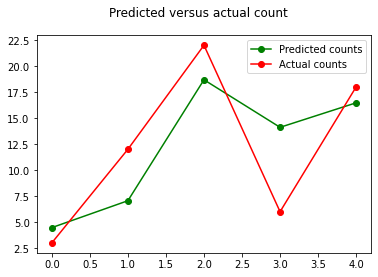

In [6]:
#Show the actual vs predicted
predicted_counts=predictions_summary_frame['mean']
actual_counts = y
fig = plt.figure()
fig.suptitle('Predicted versus actual count')
predicted, = plt.plot(X.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

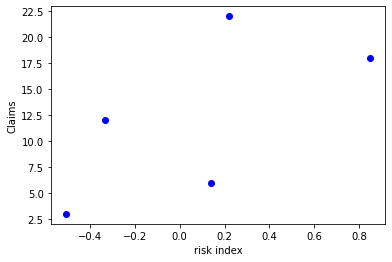

In [7]:
#Scatter Plot
plt.scatter(X['risk index'], y, c ="blue")

plt.xlabel("risk index")
plt.ylabel("Claims")
# To show the plot
plt.show()

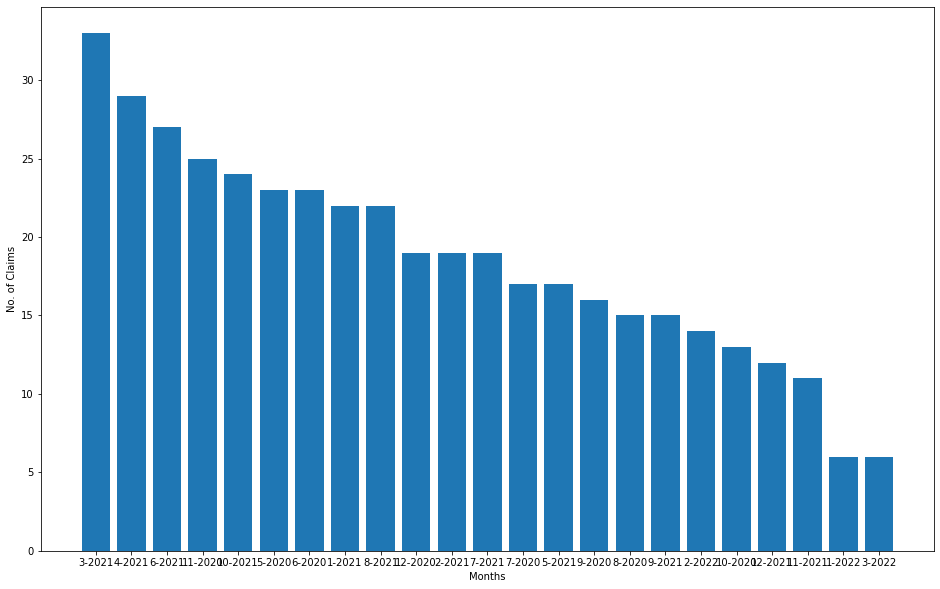

In [8]:
#Draw bar to show claims per month
claim_count = ergonomic_claim[['DateofLoss', 'ClaimNumber']]

claim_count['Month'] = pd.to_datetime(claim_count['DateofLoss']).dt.month
claim_count['Year'] = pd.to_datetime(claim_count['DateofLoss']).dt.year

claim_count['Year_month'] = claim_count['Month'].astype(str) + '-' + claim_count['Year'].astype(str)

claim_count_summary = pd.pivot_table(claim_count, index = ['Year_month'], values = ['ClaimNumber'], \
                             aggfunc = pd.Series.nunique).reset_index()
claim_count_summary = claim_count_summary.sort_values(by = ['ClaimNumber'], ascending=False)


fig = plt.figure(figsize = (16, 10))
 
# creating the bar plot
plt.bar(claim_count_summary['Year_month'], claim_count_summary['ClaimNumber'])
 
plt.xlabel("Months")
plt.ylabel("No. of Claims")
plt.show()